# Python Project 2: Portfolio Optimization and Analysis

**Author**: Chinh X. Mai, **Date**: July 3, 2022

## Project Description

This project focuses on constructing, optimizing, and analyzing a portfolio of chosen stocks in Python. Considering a realistic scenario when one has a certain amount of fund and wants to invest in the stock market either to make profit or to keep its value. He needs to know which stocks to buy and by how much. His friend has chosen some potential stocks (Table 1) and now he only needs to decide how to spend the money.


| Symbol  | Company Name                                | Last Price | Change | % Change | Volume     |
| ------- | ------------------------------------------- | ---------- | ------ | -------- | ---------- |
| ALV.DE  | Allianz SE                                  | 181.04     | \-0.16 | \-0.09%  | 1,069,053  |
| MRK.DE  | MERCK Kommanditgesellschaft auf Aktien      | 165.1      | 0.3    | 0.18%    | 313,644    |
| DTE.DE  | Deutsche Telekom AG                         | 18.84      | \-0.04 | \-0.20%  | 6,880,550  |
| VOW3.DE | Volkswagen AG                               | 138.88     | \-0.3  | \-0.22%  | 913,070    |
| DBK.DE  | Deutsche Bank Aktiengesellschaft            | 8.89       | \-0.03 | \-0.33%  | 10,112,593 |
| HNR1.DE | Hannover Rück SE                            | 136.4      | \-0.45 | \-0.33%  | 95,892     |

**Table 1**: list of suggested stocks to invest in (source: [Yahoo! Finance](https://finance.yahoo.com/quote/%5EGDAXI/components?p=%5EGDAXI), accessed on June 27, 2022)

These stocks are the components of the DAX30 Index, which includes many German blue chip companies trading on the Frankfurt Stock Exchange. This analysis will go through the process of constructing and validating the performance of a stocks portfolio that can serve the needs of the investor. This process will also provide many insights for the investor to understand the investment strategy that he can take to adjust the performance of the portfolio.

## Objectives

This project demonstrates my familiarity with many python packages used to perform a wide range of tasks necessary to optimize a portfolio. Besides the core packages used to calculate and manipulate data such as `pandas` and `numpy`, `plotly` is also used extensively to visualize stock data in the analysis and many simulations. Moreover, many utility functions and a class are generated from functions in `pypfopt` to simulate and present the optimization results. In details, the project aims to achieve the following objectives:

* Fetching stock data of chosen stocks from online source and save the data in a pandas DataFrame for further manipulations and calculations
* Investigating and cleaning the data for further analyses
* Understanding stock characteristics by calculations and visualizations
* Creating and optimizing stock portfolios for different risk preferences
* Validating and comparing the performance of these portfolios
* Constructing an efficient frontier from the chosen stocks

Besides these objectives, the project also showcases my ability to utilize flexibly different tools provided by different packages in Python and present the results in an authentic and aesthetic manner.

## Loading libraries and python options

Manually generated functions are stored in a separate python file called `portfolio.py`, these functions are also imported and called together with other functions. The logic behind each employed function will be explained briefly when it is used during the analysis.

In [1]:
# Data and array manipulation
import pandas as pd
import numpy as np
from IPython.display import display, HTML, Image
import warnings

# Datetime manipulation
import datetime as dt

# Plotting and Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import chart_studio.plotly as py
import cufflinks as cf

# Fetching stock data from web
import pandas_datareader.data as web
import yfinance as yf

# Interactive charts
from ipywidgets import interact, fixed, IntSlider
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Portfolio optimization
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import discrete_allocation
from finquant.portfolio import build_portfolio

# Self-made utilities functions
from portfolio import backtest, fnc_fetchdata, ef_summary, fnc_value, forwardtest, stock_hist

# Options
cached_data = {} 
init_notebook_mode(connected = True)
cf.go_offline()
warnings.filterwarnings(action = 'ignore')
pd.options.display.float_format = '{:,.4f}'.format

# Default graphic settings
default_yaxis = dict(showgrid = False,
                     zeroline = False,
                     showline = False,
                     showticklabels = True)
default_RgSlct = dict(buttons = list([dict(count = 1, label = "1 Month", step = "month", stepmode = "backward"),
                                      dict(count = 6, label = "6 Months", step = "month", stepmode = "backward"),
                                      dict(count = 1, label = "1 Year", step = "year", stepmode = "backward"),
                                      dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
                                      dict(label = "All Data", step = "all")]))

## Investment Scenario and analysis process

To make the case realistic, an investment scenario is considered as follows. Usually, the optimization result gives the weights of the chosen stocks in the portfolio, these weights often have the form of a fraction such as stock A accounts for 20% of the portfolio value rather than 1 or 2 stocks in the portfolio. This information is theoretically useful, but practically useless since the investor would prefer to know how many units of each stock he needs to buy (or sell) to form the portfolio. This question is regarded as the discrete allocation and requires a certain amount of fund to answer. In this project, 2,000 EUR is given to invest in the chosen stocks, the list of the chosen stock is summarized as given above.

In [2]:
# Listing the tickers of the chosen stocks
tickers = ['ALV.DE', 'MRK.DE', 'DTE.DE', 'VOW3.DE', 'DBK.DE', 'HNR1.DE']

# Fund
fund = 2000

The core philosophy of the analysis taken in this project can be summarized by the following sentence: "Applying what is learned from historical data to formulate a model that helps to predict the future". Detailed steps are explained as follows. Firstly, historical data is loaded. Stock data are time series, when the data of many stocks are presented in the same table, a table data is created. To make it more practical, the loaded data is separated into two windows. The first window is regarded as the "training window", the data in this window is used to construct optimized portfolios. The second window is called the "testing window", the data of which is used to validate the performance of the portfolios and also to understand the effect of each stock on this performance. Last but not least, an efficient frontier is constructed to present how these portfolios are relevant to each other.

## Fetching data

Firstly, the data is fetched from Yahoo! Finance using the function `fnc_fetchdata`, which receives the list of tickers of chosen stocks, start day and end day, and returns a data table that contains information about `Date`, `Ticker`, `Open` price, `High` price, `Low` price, `Close` price, `Adj Close` price, and traded `Volume` for the chosen time period. This is the standard information that Yahoo! Finance provides, and can be downloaded directly from the platform's [website](https://finance.yahoo.com/). This table is stored in the valuable `df` and regarded as the master table. When time data is not given to the function `fnc_fetchdata`, all available data is loaded, so the master table includes all available information of each stock.

In [3]:
# full data
df = fnc_fetchdata(t = tickers)
df.head()

[*********************100%***********************]  6 of 6 completed


Date  Ticker     Open     High      Low    Close  Adj Close  \
0 1996-12-16  ALV.DE 145.1380 145.2070 143.6730 144.1590    66.7052   
1 1996-12-17  ALV.DE 143.2130 143.2130 140.7590 141.5260    65.4868   
2 1996-12-18  ALV.DE 142.1390 142.5480 140.1960 140.6560    65.0843   
3 1996-12-19  ALV.DE 141.3720 141.4740 139.7360 140.0940    64.8242   
4 1996-12-20  ALV.DE 141.3720 142.6500 140.9120 141.4740    65.4628   

        Volume  
0  58,799.0000  
1  76,694.0000  
2  76,182.0000  
3  96,634.0000  
4 131,913.0000

For this analysis, I would only use the adjusted closing prices of these stocks as they "amends a stock's closing price to reflect that stock's value after accounting for any corporate actions" ([Investopedia, 2020, accessed on July 3, 2022](https://www.investopedia.com/terms/a/adjusted_closing_price.asp#:~:text=Key%20Takeaways-,The%20adjusted%20closing%20price%20amends%20a%20stock%27s%20closing%20price%20to,price%20before%20the%20market%20closes.)) to construct further analyses. This is done easily also by the function `fnc_fetchdata` as follows.

In [4]:
# fetching data of adjusted closing prices
df_price = fnc_fetchdata(t = tickers, c = 'Adj Close')
df_price.head()

[*********************100%***********************]  6 of 6 completed
Extracting column Adj Close


Ticker      ALV.DE  DBK.DE  DTE.DE  HNR1.DE  MRK.DE  VOW3.DE
Date                                                        
1996-11-18     NaN 16.5037  5.5789      NaN     NaN      NaN
1996-11-19     NaN 16.5801  5.5789      NaN     NaN      NaN
1996-11-20     NaN 16.5917  5.4223      NaN     NaN      NaN
1996-11-21     NaN 16.5245  5.4070      NaN     NaN      NaN
1996-11-22     NaN 16.4643  5.4972      NaN     NaN      NaN

This wide table contains information of the adjusted closing prices of all the chosen stocks, each of which is stored in a table's column. This is regarded as the price table and stored in the variable `df_price`.

## Data description and cleaning

Stock data provided by Yahoo! Finance is usually quite clean, but it is still necessary to check its completeness. Firstly, let us see the data counts of all stocks

In [5]:
# check start date, end date, and length of each ticker
df.groupby('Ticker')['Date'].agg(['min', 'max', 'count'])

min        max  count
Ticker                              
ALV.DE  1996-12-16 2022-07-04   6549
DBK.DE  1996-11-18 2022-07-04   6569
DTE.DE  1996-11-18 2022-07-04   6569
HNR1.DE 2000-10-23 2022-07-04   5544
MRK.DE  1998-06-26 2022-07-04   6150
VOW3.DE 1998-07-22 2022-07-04   6132

As can be seen from the table, the number of observations of these stocks are different, some observations are missing or not available. This is understandable and might not be caused by missing data as stock data is only available when the company being considered starts selling its stocks. 

Next the master table is used to check whether there is any missing prices in the daily data.

In [6]:
# Counting null values
df.isnull().sum()

Date         0
Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

As can be seen from the NA counts table, if the data of a day is not missing, all prices are available. The summary table of the price data is given below, these statistics are calculated using all the available observations. The table only gives a rough image about the characteristics since the numbers of observations are not similar

In [7]:
df_price.describe()

Ticker     ALV.DE     DBK.DE     DTE.DE    HNR1.DE     MRK.DE    VOW3.DE
count  6,549.0000 6,569.0000 6,569.0000 5,544.0000 6,150.0000 6,132.0000
mean     101.0203    26.0792     8.6247    57.5045    50.9008    78.0483
std       50.5492    12.6084     4.5160    47.1940    44.4677    56.7920
min       21.3237     4.7684     2.9908     8.7968     6.2921    10.9888
25%       54.3509    15.5851     5.1575    19.5253    16.2322    18.8198
50%       89.5923    25.8795     6.3582    30.2653    32.1021    71.0952
75%      143.8100    33.4013    11.6511    95.1863    82.2381   127.5399
max      220.2194    64.5286    34.4515   183.2961   227.0566   228.3794

Before going to further analyses, the rows containing NA values are dropped from the tables to make it more convenient to calculate other statistics.

In [8]:
df.dropna(inplace = True)
df_price.dropna(inplace = True)

## Calculations

Firstly the training and testing windows are generated, because I am interested in knowing whether what has been learned in the training window is still true in the testing window. For cross sectional data, this process usually involves the random sampling of data. However, for time series data, random sampling cannot be used since the data is usually auto-correlated, so the training and testing windows are two time windows that are next to each other so that what is learned in the training window can still be true in the testing window. In this project, I use the data of seven years from July 2010 to July 2017 as the training data, and the data after that to the date this analysis is conducted as the testing data.

In [9]:
# Setting training windows for calculating portfolio weights
start_train = dt.datetime(2010, 6, 30)
end_train = dt.datetime(2017, 6, 30)

# Setting testing windows for verifying portfolio performance
start_test = dt.datetime(2017, 7, 1)
end_test = dt.datetime(2022, 7, 1)

The first information to calculate is the daily returns. The raw data only contains information of the daily prices, but this information might be not so convenient to visualize and analyze due to its scale and autocorrelation. The prices of some stocks might be greatly higher than those of other stocks. When visualized on the same chart, it might be very hard to detect the trend in the prices of the stocks that are lower due to the wider volatilities in the prices of the stocks that are higher. Auto-correlation in the prices makes it difficult to see the correlation in the prices of different stocks when presented on a scatter plot. These phenomenons are easily eliminated by using returns instead of the raw prices. 

Daily returns can be calculated either by using the log returns or percentage changes. For this project, percentage changes are used. For daily data, the daily percentage change on a particular day $t$ for a stock is denoted as $r_t$ and calculated from the closing prices $p_t$ and $p_{t-1}$ using the following formula

$$r_t = \frac{p_t}{p_{t-1}} - 1$$

In Python, daily returns are calculated easily using the method `pct_change`. Usually, when calculating returns, the return of the first day in the considered window is not available. However, in this scenario, the prices of all days are available, and the training window is 10 years away from the oldest data, so we can have the returns of all days in the training window.

In [10]:
# Calculating daily returns
df_return = df_price.pct_change().iloc[1:, :]
df_return.loc[start_train:end_train]

Ticker      ALV.DE  DBK.DE  DTE.DE  HNR1.DE  MRK.DE  VOW3.DE
Date                                                        
2010-06-30  0.0058  0.0152  0.0008   0.0058 -0.0061  -0.0143
2010-07-01 -0.0217 -0.0364  0.0018  -0.0037 -0.0215  -0.0333
2010-07-02  0.0046  0.0012 -0.0191   0.0028 -0.0056   0.0014
2010-07-05 -0.0099 -0.0040  0.0116   0.0013 -0.0045  -0.0010
2010-07-06  0.0237  0.0195  0.0132   0.0191  0.0220   0.0197
...            ...     ...     ...      ...     ...      ...
2017-06-26  0.0037  0.0094 -0.0024   0.0043 -0.0027   0.0049
2017-06-27 -0.0011  0.0319 -0.0229  -0.0057 -0.0126  -0.0015
2017-06-28  0.0000  0.0142  0.0003  -0.0038 -0.0119   0.0019
2017-06-29 -0.0072  0.0054 -0.0209  -0.0005 -0.0217  -0.0100
2017-06-30 -0.0040 -0.0190 -0.0116  -0.0005 -0.0005   0.0026

[1780 rows x 6 columns]

The next metric to calculate is cumulative return. The cumulative return of a stock answer a more practical question. Suppose that I want to invest in a stock for a certain period and the stock does not pay dividend, then I would like to know how much I would get from the increase in the stock price afer the investment period I would like to have. In this case, the investment period is five years. Denoting the initial stock price as $p_t$ then the change in price of the stock between the period $t$ and $t + k$ is 

$$
p_{t+k} = \Pi^r_{j = 1} (1 + r_j) \times p_t
$$

which means the final price is the initial price compouned by the returns over the chosen period and the cumulative return is $\Pi^r_{j = 1} (1 + r_j)$. The cummulative returns of the chosen stocks are calculated as follows

In [11]:
# calculating cumulative returns for the training windows
df_cumprice_W1 = (1 + df_return.loc[start_train:end_train]).cumprod()
df_cumprice_W1

Ticker      ALV.DE  DBK.DE  DTE.DE  HNR1.DE  MRK.DE  VOW3.DE
Date                                                        
2010-06-30  1.0058  1.0152  1.0008   1.0058  0.9939   0.9857
2010-07-01  0.9839  0.9783  1.0026   1.0021  0.9725   0.9529
2010-07-02  0.9884  0.9795  0.9834   1.0050  0.9670   0.9542
2010-07-05  0.9786  0.9755  0.9948   1.0063  0.9627   0.9533
2010-07-06  1.0018  0.9946  1.0079   1.0255  0.9839   0.9721
...            ...     ...     ...      ...     ...      ...
2017-06-26  2.9533  0.4783  2.5339   3.6828  4.0638   2.0701
2017-06-27  2.9499  0.4935  2.4759   3.6619  4.0125   2.0670
2017-06-28  2.9499  0.5005  2.4767   3.6480  3.9648   2.0709
2017-06-29  2.9287  0.5032  2.4249   3.6463  3.8787   2.0501
2017-06-30  2.9169  0.4937  2.3967   3.6446  3.8768   2.0555

[1780 rows x 6 columns]

The volatility of each stock can be explained by either the changes in the price of that stock or the changes in the price of other stocks. This is presented by the variance - covariance matrix. 

In [12]:
# Varirance - Covariance matrix
Mcov_W1 = df_return.loc[start_train:end_train].cov()
Mcov_W1

Ticker   ALV.DE  DBK.DE  DTE.DE  HNR1.DE  MRK.DE  VOW3.DE
Ticker                                                   
ALV.DE   0.0003  0.0003  0.0001   0.0002  0.0001   0.0002
DBK.DE   0.0003  0.0006  0.0002   0.0002  0.0001   0.0003
DTE.DE   0.0001  0.0002  0.0002   0.0001  0.0001   0.0001
HNR1.DE  0.0002  0.0002  0.0001   0.0002  0.0001   0.0001
MRK.DE   0.0001  0.0001  0.0001   0.0001  0.0002   0.0001
VOW3.DE  0.0002  0.0003  0.0001   0.0001  0.0001   0.0005

Correlation matrix is the standardized version of the variance - covariance matrix.

In [13]:
# Correlation matrix
Mcorr_W1 = df_return.loc[start_train:end_train].corr()
Mcorr_W1

Ticker   ALV.DE  DBK.DE  DTE.DE  HNR1.DE  MRK.DE  VOW3.DE
Ticker                                                   
ALV.DE   1.0000  0.7403  0.6180   0.7111  0.4992   0.5542
DBK.DE   0.7403  1.0000  0.5163   0.5848  0.4190   0.5171
DTE.DE   0.6180  0.5163  1.0000   0.5128  0.4967   0.4249
HNR1.DE  0.7111  0.5848  0.5128   1.0000  0.4533   0.4554
MRK.DE   0.4992  0.4190  0.4967   0.4533  1.0000   0.3854
VOW3.DE  0.5542  0.5171  0.4249   0.4554  0.3854   1.0000

These metrics show two important characteristics of a stock in general, return and volatility. For a large number of stocks, this information is presented by the daily return table and variance covariance matrix. For a more compact view, the investor usually looks at expected returns $\mu$ and standard deviation $\sigma$. When investigating a stock, `mean` daily percentage change is the return that an investor could expect to get from investing in it for a day, so it is regarded as expected return of the stock, $E[r_t]$ or $\mu$. `std` is the standard deviation of the daily return $\sigma$, it shows the average deviation that the actual return deviates from the expected return. The larger `std` is, the further  the actual return might deviates from the expected return, so it is used to present the risk in the return of the stock. It should be noted that `mean` values in the table above is very small, but these are expected daily returns. When these returns compound over 252 trading days of a year, the equivalent annual returns would be much higher. These metrics are calculated easily by the `describe` method as follows.

In [14]:
df_return.describe().loc['mean':'std']

Ticker  ALV.DE  DBK.DE  DTE.DE  HNR1.DE  MRK.DE  VOW3.DE
mean    0.0002  0.0000  0.0002   0.0006  0.0006   0.0007
std     0.0213  0.0260  0.0184   0.0201  0.0181   0.0238

From these metrics, it can be seen that `DBK.DE` is the most volatiled stock, but it might not be the least attractive one. Usually, high volatiled stocks offer higher returns, so it is still unclear which stock is relatively better with only `mean` and `std`. In reality, it is more efficient to consider the so-called Sharpe ratio, which is calculated by the ratio

$$S_X = \frac{\mu_X - r_f}{\sigma_X}$$

where $S_X$ is the Sharpe ratio of the stock, $r_f$ is the risk-free rate, and $\mu_X, \sigma_X$ are respectively the expected return and volatility of the stock $X$. Sharpe ratio reflects how much return a stock can offer for each unit of volatility that the investor has to bear, so it is more useful for comparing between stocks. The Sharpe ratio of these stocks is calculated simply as follows.

In [15]:
_ = df_return.describe().loc['mean':'std'].T
_['S'] = _['mean'] / _['std']
_.sort_values('S', ascending = False)

mean    std      S
Ticker                      
MRK.DE  0.0006 0.0181 0.0342
HNR1.DE 0.0006 0.0201 0.0283
VOW3.DE 0.0007 0.0238 0.0276
DTE.DE  0.0002 0.0184 0.0128
ALV.DE  0.0002 0.0213 0.0112
DBK.DE  0.0000 0.0260 0.0015

The Sharpe ratio gives a better insight to the relative performance of these stocks. It can be seen that `DBK.DE` is the worst stock with regard to the Sharpe ratio. However, the investor also needs to consider the volatility when making the investment decision, since a stock can have a good Sharpe ratio but its volatility might be very high, so it might not be so attractive compared to other less volatiled stocks.

## Data Visualization

Visualization is a great mean to detect trends in data. For stock data, line, scatter plots, and correlation heatmap provide visual insight to the returns and volatilities of all selected stocks, while being very effective means for comparison of such statistics among these stocks. Firstly, let us look the line chart for price changes in the training window.

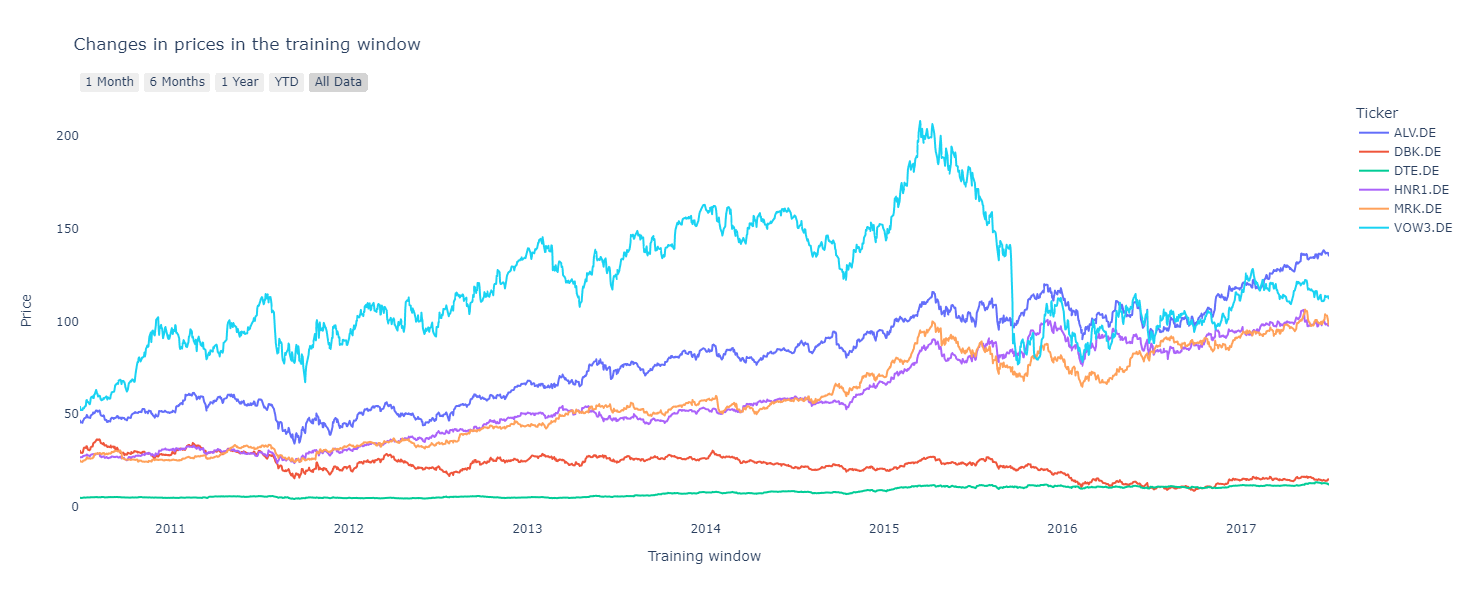

In [16]:
# Visualizing prices for the training window
fig = px.line(df_price.loc[start_train:end_train], 
              x = df_price.loc[start_train:end_train].index, 
              y = df_price.loc[start_train:end_train].columns,
              title = 'Changes in prices in the training window',
              labels = {'value': 'Price', 'x': 'Training window'},
              width = 1000, height = 600)

# Updating layout to reduce clutter
fig.update_layout(yaxis = default_yaxis, autosize = True, plot_bgcolor = 'white')

# Creating slider
fig.update_xaxes(rangeselector = default_RgSlct)

# Showing the visualization
fig.show()

The line chart seems to show four different trends in these prices. `ALV.DE`, `MRK.DE`, and `HNR1.DE1` share the same increasing trend in their prices over the training window, while `DBK.DE` had a falling trend. Price of `VOW3.DE` is the most volatiled one with a deep drop in this period, while theprice of `DTE.DE` looks comparatively stable. 

However, this chart illustrate the scale effect in prices that can be misleading for the investor as I mentioned above. The interactive chart allows for observing only the changes in price of `DTE.DE`. When considering this stock alone, the trend in its price becomes more transparent. We can observe a sharp increase in `DTE.DE`'s price over the training period, but its volatilities are much smaller than those of other stocks, so when put on the same chart, `DTE.DE` looks more stable and seems to not increase in its price. This is why we need to look at the returns chart.

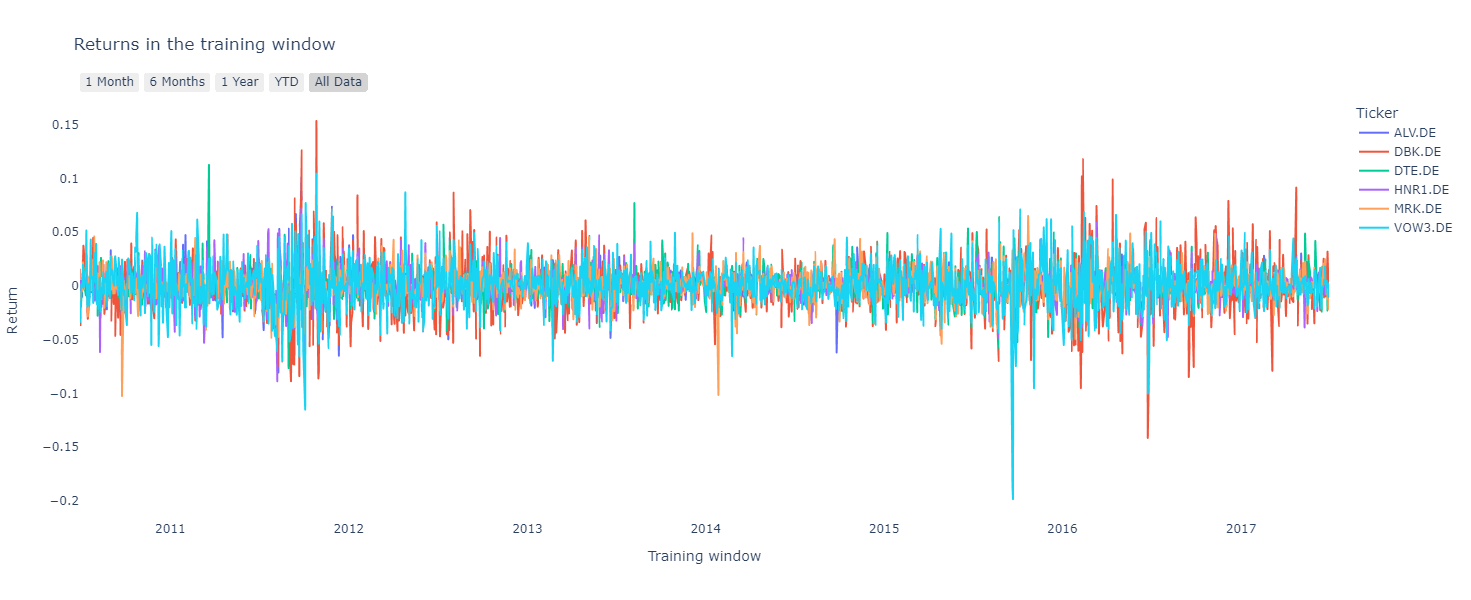

In [17]:
# Visualizing returns for the training window
fig = px.line(df_return.loc[start_train:end_train], 
              x = df_return.loc[start_train:end_train].index, 
              y = df_return.loc[start_train:end_train].columns,
              title = 'Returns in the training window',
              labels = {'value': 'Return', 'x': 'Training window'},
              width = 1000, height = 600)

# Updating layout to reduce clutter
fig.update_layout(yaxis = default_yaxis, autosize = True, plot_bgcolor = 'white')

# Creating slider
fig.update_xaxes(rangeselector = default_RgSlct)

# Showing the visualization
fig.show()

The returns chart presents changes in these prices differently. From this chart we can see that the scale effect has been eliminated and so are the trends. Instead, the volatilities are visualized clearly and we can see in which periods the stock returns are volatiled the most. The period between early 2013 and late 2014 seems to be the least volatile period of these stocks, and `VOW3.DE` is the most unstable one.

The correlations among prices of the selected stocks are illustrated more transparently by the correlation heatmap.

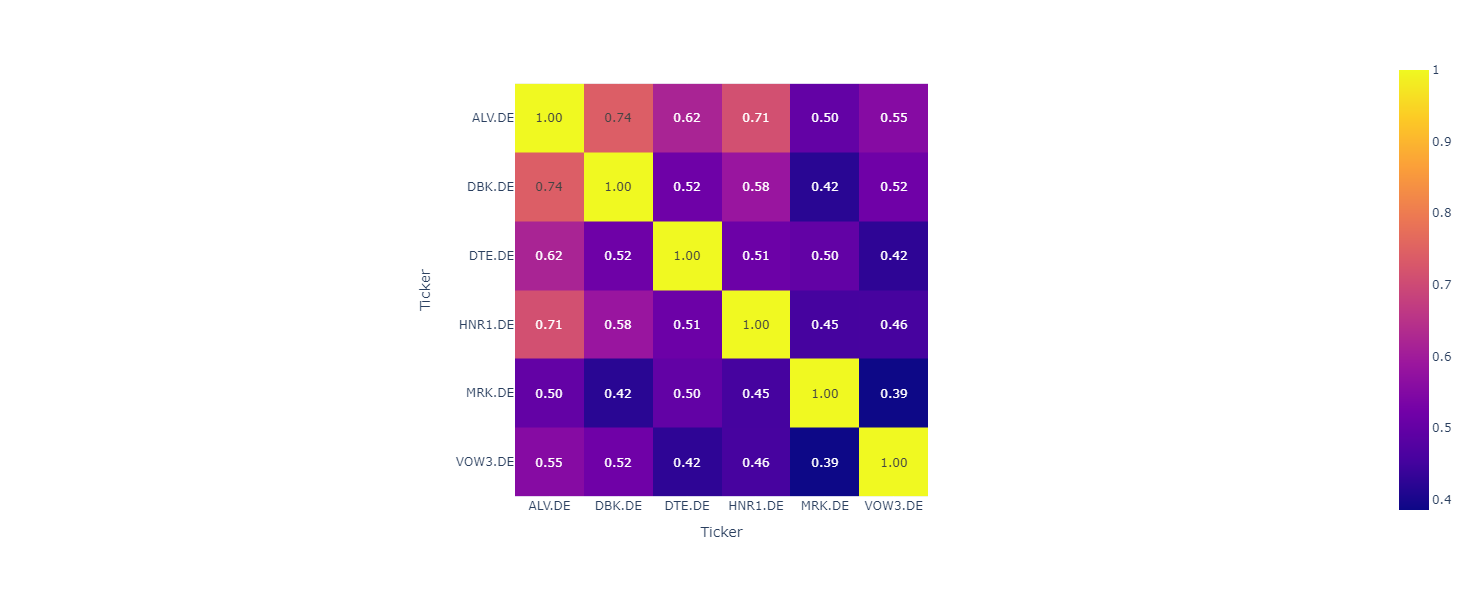

In [18]:
# Corerlation matrix
fig = px.imshow(Mcorr_W1, text_auto = '.2f', width = 600, height = 600)
fig.show()

It can be seen all stocks are correlated positively to each other. The price of `ALV.DE` is correlated strongly with other stocks, while `VOW3.DE` price is the least correlated one. With their correlations presented by color, this can be easily observed from the visualization. This information is important for constructing the portfolio as it is the core idea used to explain the diversification effect employed by the modern portfolio theory.

Next, scatter plot is used to display the relation between expected returns and volatilities of these stocks. Intuitively, the investor would want to invest in a stock that has a low volatility with a high expected return. This means stocks lying on the top left of the volatility - expected return scatter are preferred to the others.

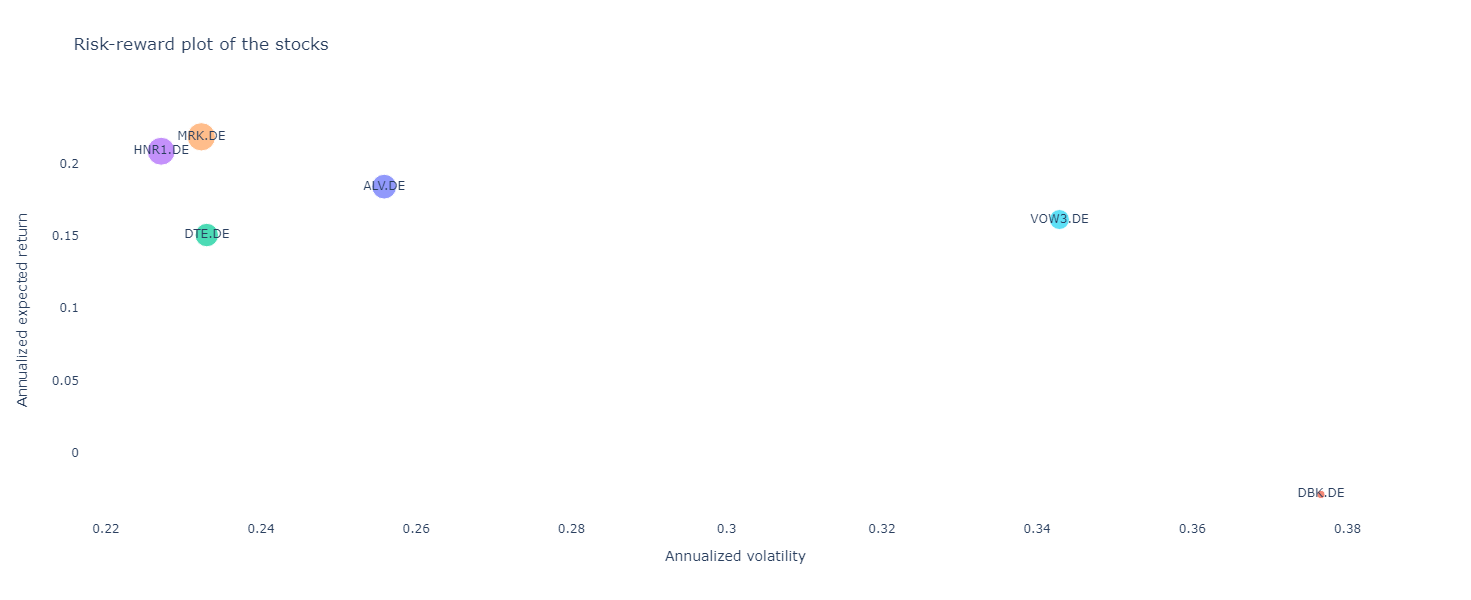

In [19]:
# Calculating annualized expected returns and volatilities
df_plot = df_return.loc[start_train:end_train].describe().iloc[1:3, :].T
df_plot['Annualized volatility'] = df_plot['std'] * np.sqrt(252)
df_plot['Annualized expected return'] = df_plot['mean'] * 252

# Risk-reward plot
fig = px.scatter(data_frame = df_plot,
                 x = 'Annualized volatility',
                 y = 'Annualized expected return',
                 text = df_plot.index,
                 color = df_plot.index,
                 size = np.abs(df_plot['Annualized expected return'] / df_plot['Annualized volatility']),
                 title = 'Risk-reward plot of the stocks',
                 height = 600,
                 width = 600)

# Updating layout to reduce clutter
fig.update_layout(showlegend = False, autosize = True, plot_bgcolor = 'white')

# Showing the visualization
fig.show()

The visualization shows exactly what has been mentioned. `MRK.DE`, `HNR1.DE` are located at the very top left of the scatter while `DBK.DE` is located in the bottom right. The size of the dot reflects the magnitude of the Sharpe ratio of the stock. Hence, the plot shows that the top performance stocks are `HNR1.DE`, `MRK.DE` and the worst one is `DBK.DE`.

Final chart of this section focuses on the backtest of the stock performance. This idea is discussed in the talk of [Daniel Roos](https://www.youtube.com/watch?v=kBwOy-6CtAQ&ab_channel=PyConSweden), where he discussed a template for analyzing stock data. Backtesting is the general method for seeing how well a strategy or model would have done ex-post and it helps assess the viability of a trading strategy ([Investopedia, 2021, accessed on July 3, 2022](https://www.investopedia.com/terms/b/backtesting.asp)). 

In [20]:
# Back test for the training windows
active = dict(zip(tickers, [True] * len(tickers)))
_ = interact(backtest, 
             symbols = fixed(tickers), 
             start_day = IntSlider(min = 3537, max = 3537 + 2557),
             time_horizon = IntSlider(min = 0, value = 365, max = 2557), **active)

interactive(children=(IntSlider(value=3537, description='start_day', max=6094, min=3537), IntSlider(value=365,…

This backtest simulates the impacts of the training window's length and the components of an equally weighted portfolio on its performance during the training window. Equally weighted is the most simple diversifying strategy usually used to illustrate the effect of diversification. By changing the components of the portfolio and the length of the training windows, we can observe their impact on the portfolio performance. 

In [21]:
Image(url = 'Figure 1.png')

**Figure 1**: Impact of the `DBK.DE` stock on the performance of the equally weighted portfolio

The simulations provide many good insights into the impact of each stock on the general performance of the portoflio. For example, when `DBK.DE` is excluded from the portfolio, its cumulative return is greatly improved (Figure 1). However, it is still not clear whether it is a good idea to exlcude this stock from the portfolio, this point will be explained further in the next sections.

## Portfolio Optimization

### A brief introduction to Markowitz's modern portfolio theory (MPT)

This section gives a brief introduction to Modern portfolio theory, the theoretical backgroun of portfolio optimization. This starts with Markowitz's modern portfolio theory. 

**Markowitz's modern portfolio theory (MPT)**

The modern portfolio theory (MPT) is a practical method for selecting securities of investment to optimize their general return within a desired level of risk. This theory was firstly presented in a paper called “Portfolio Selection” of the American economist Harry Markowitz published in the Journal of Finance in 1952, which brought him a Nobel Prize later. 

The key idea of the theory is the diversification of risks of many related stocks when put together in a portfolio. The theory assumes that investors will always want to minimize the risk for a given level of expected return when choosing a security for investment. As a result, the investor must be compensated for bearing a greater risk by receiving higher expected returns. With diversification, any collection of securities can be used to construct a portfolio that fulfill the specific desired expected returns of the investor while minimizing the risk the agent must bear.

**What is a portfolio?**

Generally, a financial asset is usually characterized by its expected return $E\left(r\right)$ or $\mu$ and risk $\sigma$. When many financial assets are bought together following certain ratios, we have a portfolio. A portfolio can consist of a wide range of assets including stocks, bonds, commodities, cash and cash equivalents, and even real estate, art, and private investments. A portfolio is also characterized by expected return $\mu_p$ and risk $\sigma_p$.

**Diversification and how it works**

The returns of related financial assets can be correlated with each other, which means that their returns tend to change together. The changes can, however, be different in magnitude and direction, so if two correlated stocks are put together in a portfolio, the investor can adjust the ratio of the two stocks to construct a portfolio that has the characteristics that he wants. Moreover, the difference in magnitude of changes can be utilized to minimize the risk so that the portfolio is less risky than it should be for a certain level of return. This phenomenon is regarded as diversification and the core mechanism of MPT.

**Portfolio optimization**

Constructing a portfolio of certain characteristics is an art because it requires the investor to combine different financial assets and choose an optimal ratio. Portfolio optimization is the process of adjusting a portfolio to make it more efficient in terms of its return over the risk that the portfolio imposes. While the MPT is available to all the investors, each agent might have his or her own adjustments to the approach to include their beliefs of the market as well as the advantage of information in the portfolio. Regardless of which adjustments are added, all investors must start at the same spot, so being able to optimize a portfolio following Markowitz’s MPT is an important step in the the process of creating one’s own way of portfolio optimization.

**Technical details**

With the expected return column vector $\mathbf{\mu}$, variance-covariance matrix $\mathbf{S}$, define $\mathbf{w}$ as the column vector of the weights of all assets in the to-be-constructed portfolio and $\mathbf{1}$ as the column vector 1, the minimum variance portfolio for each given $\mu_p$ is determined by solving the minimization problem 

$$\min_{\mathbf{w}} \mathbf{w'}\mathbf{S}\mathbf{w} \text{ w.r.t } \mathbf{w'}\mathbf{\mu} = \mu_p, \mathbf{w'}\mathbf{1} = 1$$

The objective function of this optimization problem can be changed and extra constraints can be added to reflect the differences in the preference of the investor. One might want to have a portfolio that has the highest possible Sharpe ratio, and can choose to leverage the income by allowing for short selling. These preferences can be presented in similar optimization problems in the same manner.

Regardless of this preference, the inputs always contain the variance covariance matrix $\mathbf{S}$ and the vector of expected returns $\mu$. The package `pypfopt` also provides many convenient functions to calculate these inputs. The lastest stock prices in the training window is also needed to answer the discrete allocation question.

In [22]:
# Stock statistics
mu = expected_returns.mean_historical_return(df_price.loc[start_train:end_train])
S = risk_models.CovarianceShrinkage(df_price.loc[start_train:end_train]).ledoit_wolf()

# Current stock prices
current_prices = discrete_allocation.get_latest_prices(df_price.loc[start_train:end_train])

This optimization process is simplified by the package `pypfopt`. The process is summarized in the Figure below

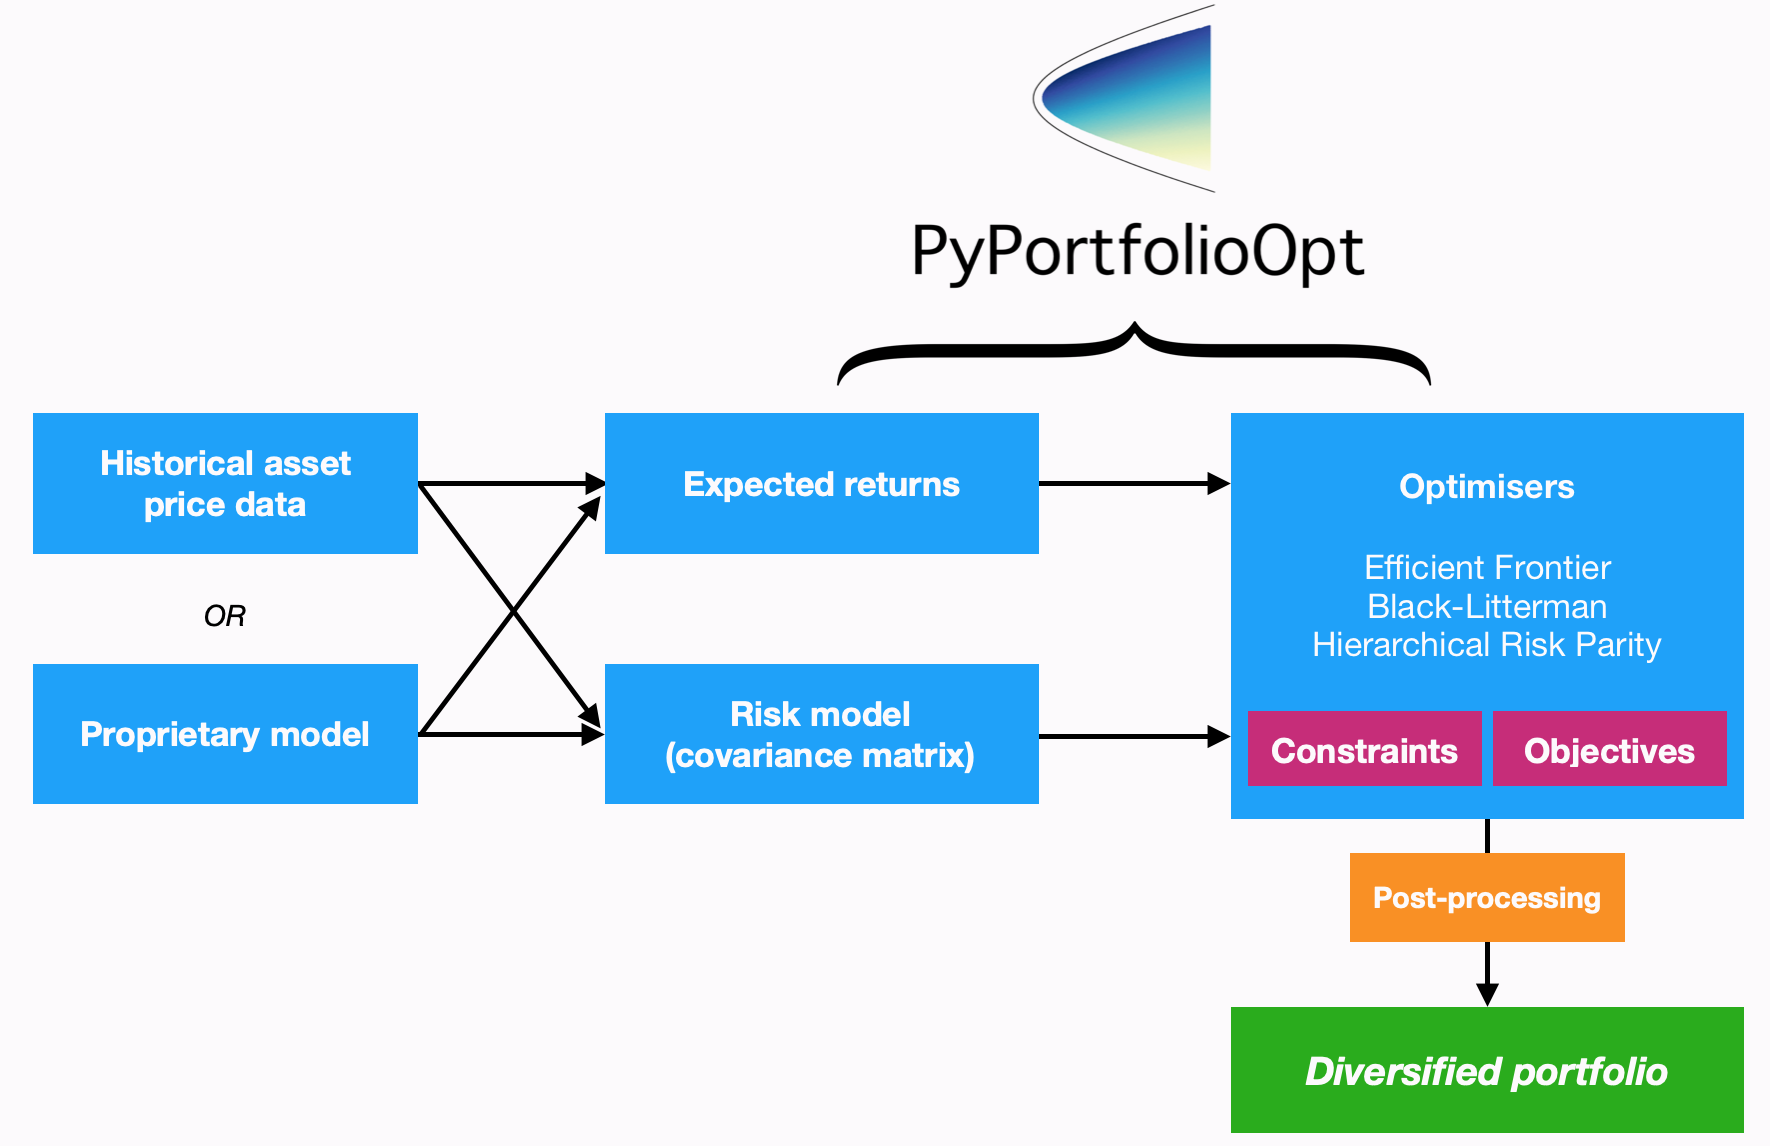

In [23]:
Image('Figure 2.png', width = 800)

**Figure 2**: The optimization process of `pypfopt` (source: [PyPortfolioOpt Manual](https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html#processing-historical-prices), accessed on July 3, 2022)

A functional class has been generated from the objects and methods provided by `pypfopt` to present the optimization results in a more informative manner. The class `ef_summary` is generated in this project to serve this purpose, details of its performance is presented in the next subsections.

In this section, four portfolios will be generated, they are:

* Minimum volatility portfolio
* Minimum volatility portfolio without short selling
* Maximum Sharpe portfolio
* Maximum Sharpe portfolio without short selling

Short position indicates the situation where the investor can leverage the portfolio by selling the cash flows of the stocks in the portfolio whose cash inflows can be used to invest in other stocks. The portfolio having maximum Sharpe ratio offers the highest possible returns for a certain level of risk. In a nutshell, the minimum volatility portfolio has the lowest possible risk for a certain level of return, while the maximum Sharpe portfolio offers the highest possible return for a certain level of risk. These characteristics of the constructed portfolio can even be customized further by changing the optimization problem.

### Minimum volatility portfolio

The `ef_summary` take the object created by the function `EfficientFrontier`, the vector of latest stock price, the fund to invest, and the type of optimization as its inputs. Currently, the function only receive two types of optimization, namely 'minimum volatility' and 'max sharpe'. A full summary of the optimization solution is then given by the method `summary`.

OPTIMIZATION RESULTS FOR MINIMUM VOLATILITY CONDITIONS:

-----------------------------------------------------------------------
1. Optimization results:
-----------------------------------------------------------------------

Portfolio weights for minimum volatility optimization:




Performance details:

Expected annual return: 21.6%
Annual volatility: 18.4%
Sharpe Ratio: 1.07
Portfolio performance: (0.2163191884851998, 0.18370829719017578, 1.0686462804778445)


-----------------------------------------------------------------------
2. Weights visualization:
-----------------------------------------------------------------------



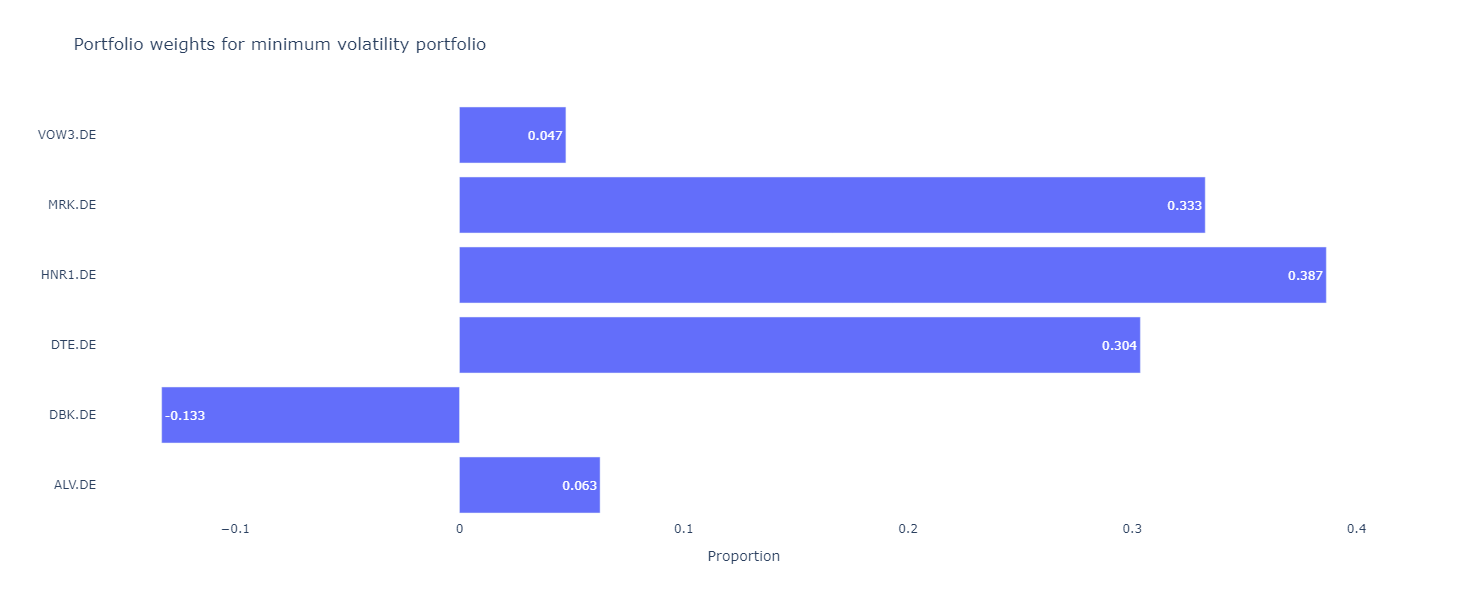



-----------------------------------------------------------------------
3. Discrete allocation:
-----------------------------------------------------------------------

The latest prices are:
 




Discrete allocation performed with $19.22 leftover as follows

{'ALV.DE': 1, 'DTE.DE': 39, 'HNR1.DE': 7, 'MRK.DE': 6, 'VOW3.DE': 1, 'DBK.DE': -17}

The detailed proportions are as follows: 

Stock: ALV.DE, value = 0.0676
Stock: DTE.DE, value = 0.2371
Stock: HNR1.DE, value = 0.3417
Stock: MRK.DE, value = 0.2948
Stock: VOW3.DE, value = 0.0563
Stock: DBK.DE, value = -0.1256


In [24]:
ef_minvol = ef_summary(EfficientFrontier(mu, S, weight_bounds = (-1, 1)), price = current_prices, fund = fund, type = 'minimum volatility')
ef_minvol.summary()

The output includes three main parts. Firstly, the optimized weights for the portfolio are given as well as the performance details of the portfolio. These weights are then visualized in the second part to make it more convenient for comparison. The third part presents the solution of the discrete allocation problem. It can be seen that the weight of `DBK.DE` is negative, this means the optimization solution suggests that the investor should have a short position in this stock.

It should be noticed that the actual weights generated by the discrete allocation is a bit different from the optimal weights produced by the optimization, and some of the fund is left over. This is similar to the real situation because it is hardly the case that the fund is fully spent.

### Minimum volatility portfolio no short

OPTIMIZATION RESULTS FOR MINIMUM VOLATILITY CONDITIONS:

-----------------------------------------------------------------------
1. Optimization results:
-----------------------------------------------------------------------

Portfolio weights for minimum volatility optimization:




Performance details:

Expected annual return: 18.3%
Annual volatility: 18.7%
Sharpe Ratio: 0.87
Portfolio performance: (0.1827095949657203, 0.18685148166172907, 0.8707963860853157)


-----------------------------------------------------------------------
2. Weights visualization:
-----------------------------------------------------------------------



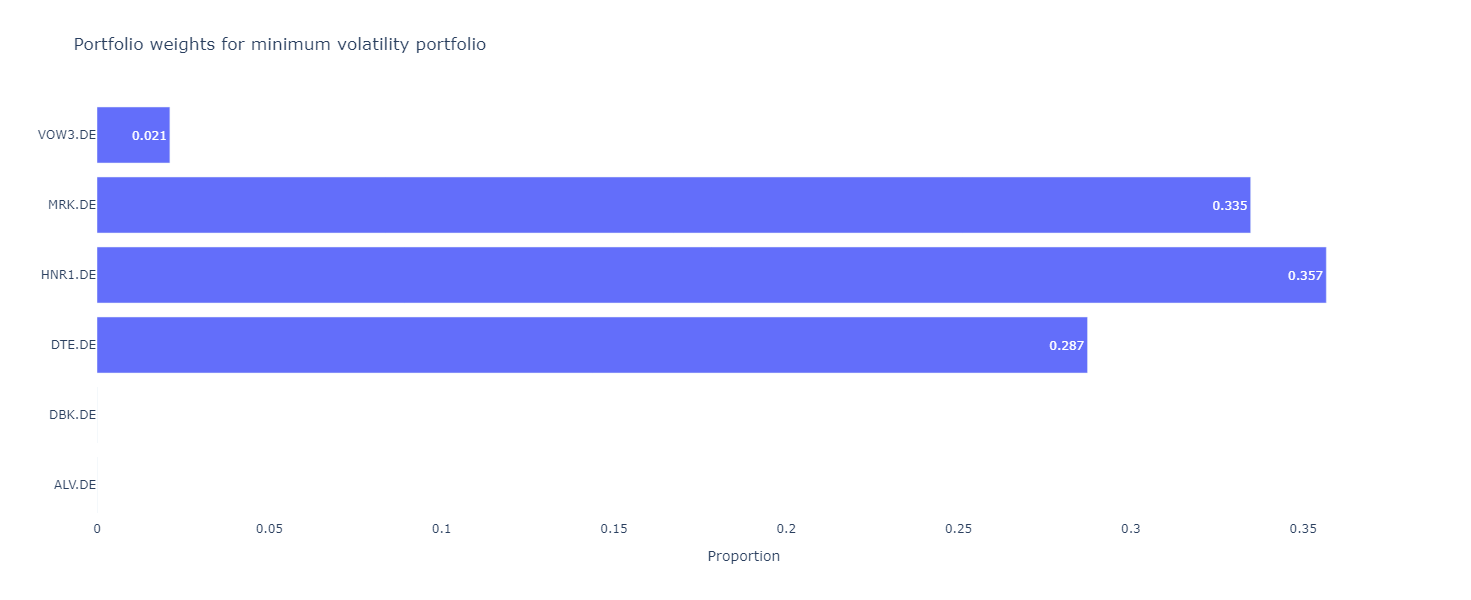



-----------------------------------------------------------------------
3. Discrete allocation:
-----------------------------------------------------------------------

The latest prices are:
 




Discrete allocation performed with $30.36 leftover as follows

{'DBK.DE': 1, 'DTE.DE': 48, 'HNR1.DE': 7, 'MRK.DE': 7}

The detailed proportions are as follows: 

Stock: DBK.DE, value = 0.0074
Stock: DTE.DE, value = 0.2918
Stock: HNR1.DE, value = 0.3417
Stock: MRK.DE, value = 0.3440


In [25]:
# Calculating the weight of minimum volatility portfolio without short positions
ef_minvol_ns = ef_summary(EfficientFrontier(mu, S), price = current_prices, fund = fund, type = 'minimum volatility')
ef_minvol_ns.summary()

### Max Sharpe portfolio

OPTIMIZATION RESULTS FOR MAX SHARPE CONDITIONS:

-----------------------------------------------------------------------
1. Optimization results:
-----------------------------------------------------------------------

Portfolio weights for max sharpe optimization:




Performance details:

Expected annual return: 42.3%
Annual volatility: 26.3%
Sharpe Ratio: 1.53
Portfolio performance: (0.4231708358049574, 0.26326428821496367, 1.5314300262242768)


-----------------------------------------------------------------------
2. Weights visualization:
-----------------------------------------------------------------------



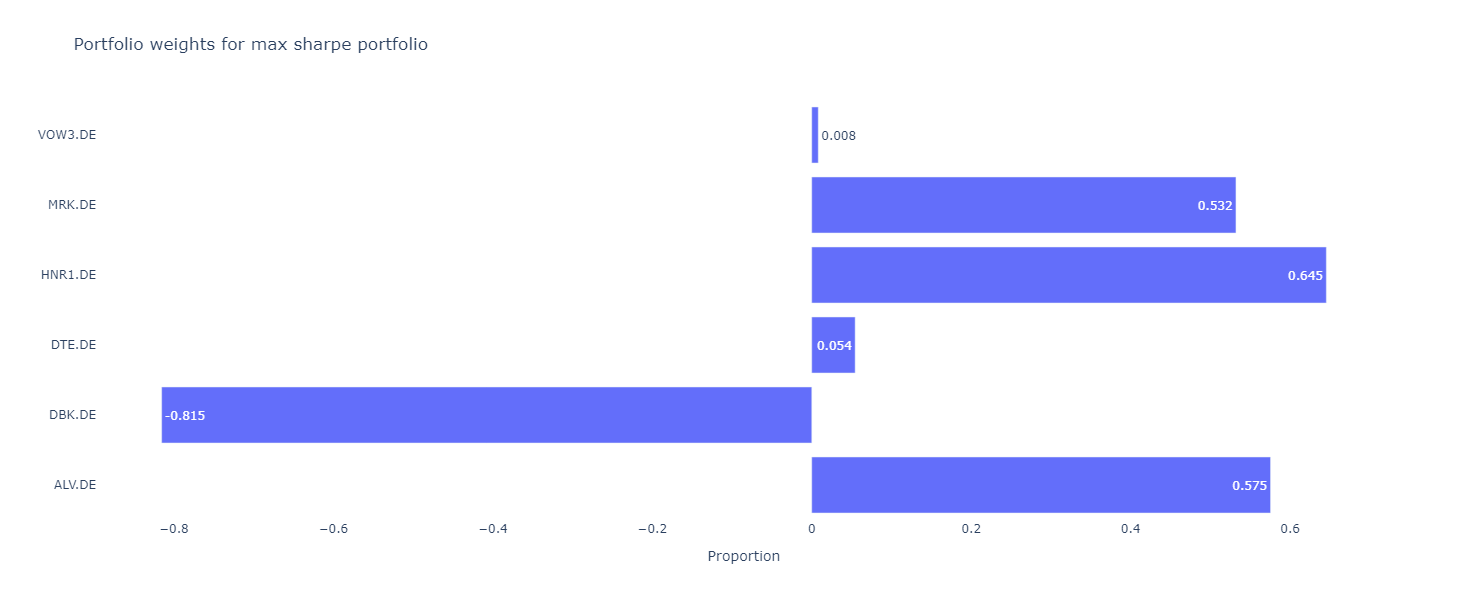



-----------------------------------------------------------------------
3. Discrete allocation:
-----------------------------------------------------------------------

The latest prices are:
 




Discrete allocation performed with $7.14 leftover as follows

{'ALV.DE': 5, 'DTE.DE': 4, 'HNR1.DE': 7, 'MRK.DE': 6, 'DBK.DE': -110}

The detailed proportions are as follows: 

Stock: ALV.DE, value = 0.3381
Stock: DTE.DE, value = 0.0243
Stock: HNR1.DE, value = 0.3417
Stock: MRK.DE, value = 0.2948
Stock: DBK.DE, value = -0.8129


In [26]:
ef_maxsharpe = ef_summary(EfficientFrontier(mu, S, weight_bounds = (-1, 1)), price = current_prices, fund = fund, type = 'max sharpe')
ef_maxsharpe.summary()

### Max Sharpe portfolio no short

OPTIMIZATION RESULTS FOR MAX SHARPE CONDITIONS:

-----------------------------------------------------------------------
1. Optimization results:
-----------------------------------------------------------------------

Portfolio weights for max sharpe optimization:




Performance details:

Expected annual return: 20.7%
Annual volatility: 19.6%
Sharpe Ratio: 0.95
Portfolio performance: (0.2066600112314858, 0.19610524452189124, 0.9518358965185603)


-----------------------------------------------------------------------
2. Weights visualization:
-----------------------------------------------------------------------



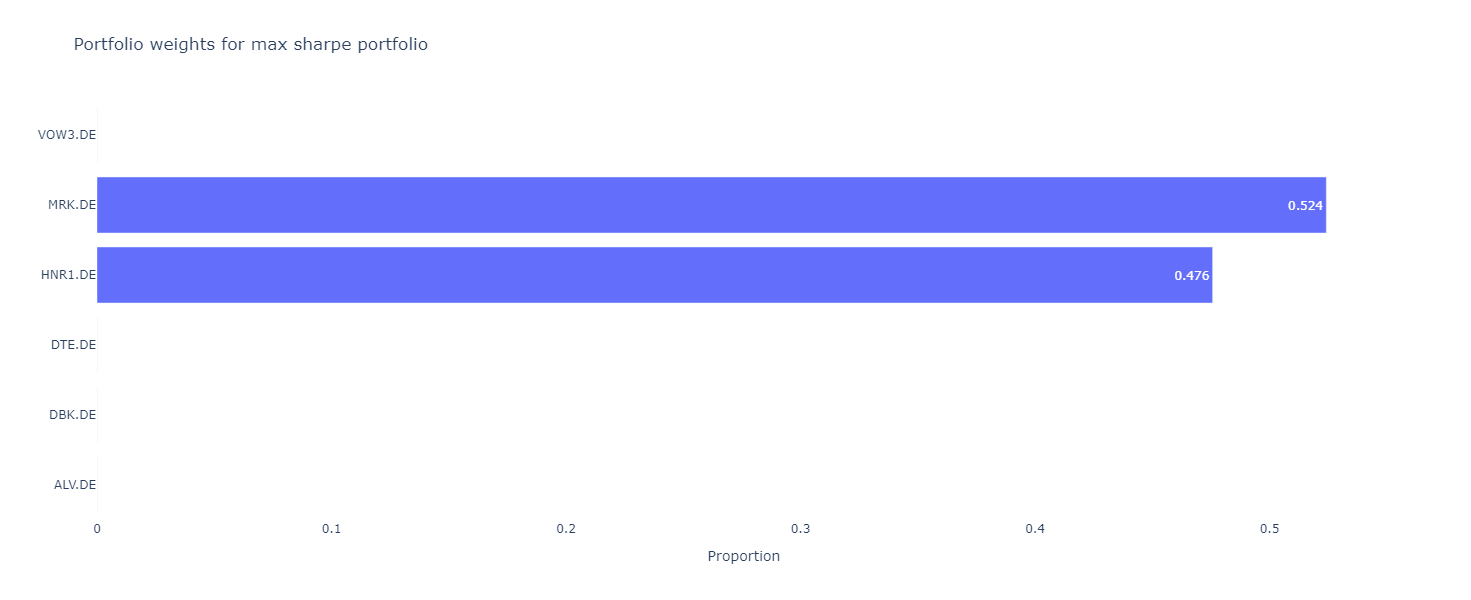



-----------------------------------------------------------------------
3. Discrete allocation:
-----------------------------------------------------------------------

The latest prices are:
 




Discrete allocation performed with $14.07 leftover as follows

{'DBK.DE': 1, 'DTE.DE': 1, 'HNR1.DE': 10, 'MRK.DE': 10}

The detailed proportions are as follows: 

Stock: DBK.DE, value = 0.0074
Stock: DTE.DE, value = 0.0061
Stock: HNR1.DE, value = 0.4881
Stock: MRK.DE, value = 0.4914


In [27]:
ef_maxsharpe_ns = ef_summary(EfficientFrontier(mu, S), price = current_prices, fund = fund, type = 'max sharpe')
ef_maxsharpe_ns.summary()

### Portfolio statistics in the training window

Components of the optimized portfolios are shown below. It is important to calculate their statistics in the training window so that they can be compared with those of the testing window to see whether the performance is consistent ex-ante.

In [28]:
# Taking portfolio information from the summary objects
portfolio_minvol = ef_minvol.allocation
portfolio_minvol_ns = ef_minvol_ns.allocation
portfolio_maxsharpe = ef_maxsharpe.allocation
portfolio_maxsharpe_ns = ef_maxsharpe_ns.allocation

# Printing portfolio discrete allocation
print(f'The minimum volatility portfolio is: {portfolio_minvol}')
print(f'The minimum volatility no short portfolio is: {portfolio_minvol_ns}')
print(f'The maximum Sharpe ratio portfolio is: {portfolio_maxsharpe}')
print(f'The maximum Sharpe ratio no short portfolio is: {portfolio_maxsharpe_ns}')

The minimum volatility portfolio is: {'ALV.DE': 1, 'DTE.DE': 39, 'HNR1.DE': 7, 'MRK.DE': 6, 'VOW3.DE': 1, 'DBK.DE': -17}
The minimum volatility no short portfolio is: {'DBK.DE': 1, 'DTE.DE': 48, 'HNR1.DE': 7, 'MRK.DE': 7}
The maximum Sharpe ratio portfolio is: {'ALV.DE': 5, 'DTE.DE': 4, 'HNR1.DE': 7, 'MRK.DE': 6, 'DBK.DE': -110}
The maximum Sharpe ratio no short portfolio is: {'DBK.DE': 1, 'DTE.DE': 1, 'HNR1.DE': 10, 'MRK.DE': 10}


Statistics of these portfolio in the training window are gathered as follows

In [29]:
# Gathering portfolio performance
performance_minvol_train = ef_minvol.ef.portfolio_performance()
performance_minvolns_train = ef_minvol_ns.ef.portfolio_performance()
performance_maxsharpe_train = ef_maxsharpe.ef.portfolio_performance()
performance_maxsharpens_train = ef_maxsharpe_ns.ef.portfolio_performance()

pd.DataFrame([performance_minvol_train, 
              performance_minvolns_train, 
              performance_maxsharpe_train, 
              performance_maxsharpens_train],
             columns = ['mean', 'std', 'S'], 
             index = ['Minimum Volatility', 'Minimum Volatility NS', 'Max Sharpe', 'Max Sharpe NS']).sort_values('S', ascending = False)

mean    std      S
Max Sharpe            0.4232 0.2633 1.5314
Minimum Volatility    0.2163 0.1837 1.0686
Max Sharpe NS         0.2067 0.1961 0.9518
Minimum Volatility NS 0.1827 0.1869 0.8708

These are the annualized statistics of the optimization results. It can be seen that portfolios that allow for short selling generally have higher Sharpe ratios than those without short selling. Furthermore, the `Max Sharpe` portfolios outperform the `Minimum Volatility` ones. With the testing window, we can see whether this insight still holds.

## Portfolio Analysis

In this section, the performance of the four portfolios above is validated in the testing window. The idea is quite simple. The performance of these portfolios will be evaluated using their cumulative returns over the testing period. Then a forwardtest, which is the opposite of the backtest constructed in the visualization section, is simulated to detect the impact of each stock on the future performance of the portfolios. Firstly, the actual stock allocations of the portfolios are listed below.

In [30]:
# Printing portfolio discrete allocation
print(f'The minimum volatility portfolio is: {portfolio_minvol}')
print(f'The minimum volatility no short portfolio is: {portfolio_minvol_ns}')
print(f'The maximum Sharpe ratio portfolio is: {portfolio_maxsharpe}')
print(f'The maximum Sharpe ratio no short portfolio is: {portfolio_maxsharpe_ns}')

The minimum volatility portfolio is: {'ALV.DE': 1, 'DTE.DE': 39, 'HNR1.DE': 7, 'MRK.DE': 6, 'VOW3.DE': 1, 'DBK.DE': -17}
The minimum volatility no short portfolio is: {'DBK.DE': 1, 'DTE.DE': 48, 'HNR1.DE': 7, 'MRK.DE': 7}
The maximum Sharpe ratio portfolio is: {'ALV.DE': 5, 'DTE.DE': 4, 'HNR1.DE': 7, 'MRK.DE': 6, 'DBK.DE': -110}
The maximum Sharpe ratio no short portfolio is: {'DBK.DE': 1, 'DTE.DE': 1, 'HNR1.DE': 10, 'MRK.DE': 10}


It can be seen that the total number of stocks in the portfolios that allow for short position is much higher than those of the portfolios that do not allow for the short position. This is achieved by short selling low-cost stocks and use acquired money to invest in the more profitable stocks. This will be explained further during this performance analysis. 

To validate the performance of these portfolios using cumulative returns, the reasonable first step is to calculate their cumulative returns of the testing period. To simplify this task, I create another function called `fnc_value`, which calculates the portfolio value for a certain period and returns the daily value of the portfolio in a series. The table containing prices of all stocks and portfolios is given below.

In [31]:
# Calculating portfolio prices for forward test
minvol_price_test = fnc_value(portfolio = portfolio_minvol, master_df = df, start = start_test)
minvolns_price_test = fnc_value(portfolio = portfolio_minvol_ns, master_df = df, start = start_test)
maxsharpe_price_test = fnc_value(portfolio = portfolio_maxsharpe, master_df = df, start = start_test)
maxsharpens_price_test = fnc_value(portfolio = portfolio_maxsharpe_ns, master_df = df, start = start_test)

# Combined with stock price data
price_portfolio_test = df_price[df_price.index >= start_test]
price_portfolio_test['Min Volatility'] = minvol_price_test
price_portfolio_test['Min Volatility NS'] = minvolns_price_test
price_portfolio_test['Max Sharpe'] = maxsharpe_price_test
price_portfolio_test['Max Sharpe NS'] = maxsharpens_price_test

# final set
price_portfolio_test

Ticker       ALV.DE  DBK.DE  DTE.DE  HNR1.DE   MRK.DE  VOW3.DE  \
Date                                                             
2017-07-03 137.9996 15.3233 12.2388  98.7396  97.5785 114.7443   
2017-07-04 138.5880 15.6089 12.1228  99.2047  96.6956 115.0823   
2017-07-05 138.6272 15.5756 12.0300 100.1349  96.8350 114.6176   
2017-07-06 138.9803 15.8945 12.0262 100.2279  95.1623 116.6877   
2017-07-07 140.2355 15.8802 12.0416 100.7395  94.7906 117.2369   
...             ...     ...     ...      ...      ...      ...   
2022-06-28 183.1000  8.8630 19.0680 137.5000 163.7000 140.8200   
2022-06-29 183.7200  8.5710 19.0340 137.0500 160.8000 134.4600   
2022-06-30 182.1200  8.3180 18.9460 138.5000 161.0000 127.4200   
2022-07-01 182.0000  8.0530 19.2160 140.1500 165.7000 127.4800   
2022-07-04 184.0400  8.1320 19.3140 142.2000 165.5000 127.4200   

Ticker      Min Volatility  Min Volatility NS  Max Sharpe  Max Sharpe NS  
Date                                                                      
2017-07-03      1,746.2112         1,977.0143    330.0418     1,990.7432  
2017-07-04      1,735.7165         1,968.8073    299.0607     1,986.7353  
2017-07-05      1,739.5857         1,971.8063    309.8986     1,997.3049  
2017-07-06      1,727.0506         1,960.8814    267.1798     1,981.8225  
2017-07-07      1,731.0519         1,962.5886    276.4397     1,983.2224  
...                    ...                ...         ...            ...  
2022-06-28      2,861.6010         3,032.5270  1,961.5420     3,039.9310  
2022-06-29      2,838.9491         3,007.1531  1,976.0760     3,006.1051  
2022-06-30      2,842.5280         3,014.2260  2,006.9040     3,022.2640  
2022-07-01      2,897.2529         3,071.3709  2,076.2839     3,085.7689  
2022-07-04      2,914.8279         3,089.1059  2,091.1160     3,104.4480  

[1269 rows x 10 columns]

It should be noticed that the initial portfolio value of the portfolios with short position is lower than the invested fund. This can be explained roughly by the short positions taken while constructing the portfolios. Statistics of the stocks and these portfolios are summarized below.

In [32]:
# Portfolio statistics
return_portfolio_test = price_portfolio_test.pct_change().describe().loc['mean':'std'].T
return_portfolio_test['S'] = return_portfolio_test['mean'] / return_portfolio_test['std']
return_portfolio_test.sort_values('S', ascending = False)

mean    std       S
Ticker                                  
Max Sharpe         0.0019 0.0313  0.0612
Min Volatility     0.0005 0.0123  0.0391
Min Volatility NS  0.0004 0.0120  0.0353
DTE.DE             0.0004 0.0127  0.0347
MRK.DE             0.0005 0.0157  0.0344
Max Sharpe NS      0.0004 0.0133  0.0330
HNR1.DE            0.0004 0.0165  0.0257
ALV.DE             0.0004 0.0161  0.0222
VOW3.DE            0.0003 0.0226  0.0149
DBK.DE            -0.0002 0.0260 -0.0061

In [33]:
return_portfolio_test.sort_values('std')

mean    std       S
Ticker                                  
Min Volatility NS  0.0004 0.0120  0.0353
Min Volatility     0.0005 0.0123  0.0391
DTE.DE             0.0004 0.0127  0.0347
Max Sharpe NS      0.0004 0.0133  0.0330
MRK.DE             0.0005 0.0157  0.0344
ALV.DE             0.0004 0.0161  0.0222
HNR1.DE            0.0004 0.0165  0.0257
VOW3.DE            0.0003 0.0226  0.0149
DBK.DE            -0.0002 0.0260 -0.0061
Max Sharpe         0.0019 0.0313  0.0612

Performance of these portfolios have changed during the testing window. Generally in the tesing window, it is no longer true that the `Max Sharpe` portfolios outperform the `Minimum Volatility` ones in terms of the Sharpe ratio, but the portfolios allowing for short selling still have higher Sharpe ratios.

Next, let us look at the cumulative returns of these stocks and portfolios.

In [34]:
# cumulative returns
cumreturn_portfolio = (1 + price_portfolio_test.pct_change().iloc[1:, :]).cumprod()
cumreturn_portfolio

Ticker      ALV.DE  DBK.DE  DTE.DE  HNR1.DE  MRK.DE  VOW3.DE  Min Volatility  \
Date                                                                           
2017-07-04  1.0043  1.0186  0.9905   1.0047  0.9910   1.0029          0.9940   
2017-07-05  1.0045  1.0165  0.9829   1.0141  0.9924   0.9989          0.9962   
2017-07-06  1.0071  1.0373  0.9826   1.0151  0.9752   1.0169          0.9890   
2017-07-07  1.0162  1.0363  0.9839   1.0203  0.9714   1.0217          0.9913   
2017-07-10  1.0233  1.0301  0.9918   1.0254  0.9719   1.0210          0.9971   
...            ...     ...     ...      ...     ...      ...             ...   
2022-06-28  1.3268  0.5784  1.5580   1.3926  1.6776   1.2273          1.6387   
2022-06-29  1.3313  0.5593  1.5552   1.3880  1.6479   1.1718          1.6258   
2022-06-30  1.3197  0.5428  1.5480   1.4027  1.6500   1.1105          1.6278   
2022-07-01  1.3188  0.5255  1.5701   1.4194  1.6981   1.1110          1.6592   
2022-07-04  1.3336  0.5307  1.5781   1.4402  1.6961   1.1105          1.6692   

Ticker      Min Volatility NS  Max Sharpe  Max Sharpe NS  
Date                                                      
2017-07-04             0.9958      0.9061         0.9980  
2017-07-05             0.9974      0.9390         1.0033  
2017-07-06             0.9918      0.8095         0.9955  
2017-07-07             0.9927      0.8376         0.9962  
2017-07-10             0.9970      0.8970         0.9990  
...                       ...         ...            ...  
2022-06-28             1.5339      5.9433         1.5270  
2022-06-29             1.5211      5.9874         1.5100  
2022-06-30             1.5246      6.0808         1.5182  
2022-07-01             1.5535      6.2910         1.5501  
2022-07-04             1.5625      6.3359         1.5594  

[1268 rows x 10 columns]

The table of cumulative returns show a very attractive picture. The `Max Sharpe` portfolio with short selling offers a very high cumulative return, up to approximately 6.3. That means the portfolio value will be more than six times higher at the end of the testing window. Furthermore, when no short selling is allowed, the cumulative returns of the `Min Volatility` and `Max Sharpe` portfolios are approximately the same, this will make the `Min Volatility` portfolio more attractive due to its lower volatility. Using the cumulative returns and volatility, these portfolios are ranked as follows `Max Sharpe` > `Min Volatility` > `Min Volatility NS` > `Max Sharpe NS` in terms of performance during the testing window.

However, it is also important to consider the actual values of the portfolios. Considering the fact that these portfolios have the same initial investment cost (approximately 2,000 EUR), the actual final portfolio values show a different ranking: `Max Sharpe NS` > `Min Volatility NS` > `Min Volatility` > `Max Sharpe`. So if an investor wants a portfolio that offers the best performance in terms of portfolio value at the end of the testing windows, he should go for the `Max Sharpe NS` portfolio. This is more practical than making decision only based on the cumulative returns.

Next is the forwardtest of the portfolio performance. Unlike the backtest, the duration is fixed in the forwardtest and only the portfolio components vary. A change in the chosen components will trigger a recalculation of the four optimal portfolios and the cumulative returns. This will allow us to observe the impact of each stock on the performance of the portfolios in the testing window.

In [35]:
# Forwardtesting
active = dict(zip(tickers, [True] * len(tickers)))
_ = interact(forwardtest, 
             symbols = fixed(tickers), 
             fund = fixed(2000), 
             start_train = fixed(dt.datetime(2010, 6, 30)), 
             end_train = fixed(dt.datetime(2017, 6, 30)), 
             start_test = fixed(dt.datetime(2017, 7, 1)), 
             end_test = fixed(None),             
             **active)

interactive(children=(Checkbox(value=True, description='ALV.DE'), Checkbox(value=True, description='MRK.DE'), …

When no component is excluded from the list, it can be seen that `Max Sharpe Portfolio` outperforms other portfolios dramatically, while the other portfolios share the same trend in the changes of their cumulative returns.

Forwardtest from 2017-07-01 00:00:00 to today\
Portfolios constructed from data collected from 2010-06-30 00:00:00 to 2017-06-30 00:00:00
1. The minimum volatility portfolio is: {'ALV.DE': 1, 'MRK.DE': 6, 'DTE.DE': 39, 'VOW3.DE': 1, 'HNR1.DE': 7, 'DBK.DE': -17}
2. The minimum volatility no short portfolio is: {'MRK.DE': 7, 'DTE.DE': 48, 'DBK.DE': 1, 'HNR1.DE': 7}
3. The maximum Sharpe ratio portfolio is: {'ALV.DE': 5, 'MRK.DE': 6, 'DTE.DE': 4, 'HNR1.DE': 7, 'DBK.DE': -110}
4. The maximum Sharpe ratio no short portfolio is: {'MRK.DE': 10, 'DTE.DE': 1, 'DBK.DE': 1, 'HNR1.DE': 10}

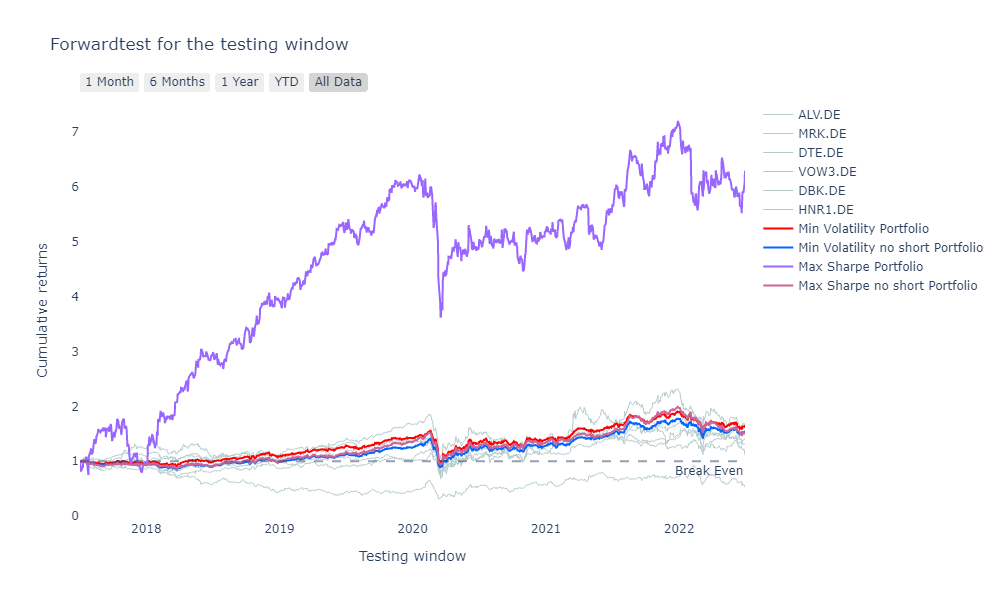

In [36]:
Image('Figure 3.png')

**Figure 3**: Cumulative returns of the stocks and portfolios during the testing window

When `HNR1.DE` is excluded from the list of portfolio components, the distance between the cumulative return of `Max Sharpe Portfolio` and the those of others increase strongly, almost triple from approximately 6.3 to approximately 18.5. This can be explained by the change in the number of stocks that the portfolio contains, the new optimal numbers of stock suggest that the investor should sell more `DBK.DE` and use the extra money to increase the number of other stocks. It can be seen that `DBK.DE` is used as a leverage to enhance the performance of the portfolio. When more leverage is used, the leverage effect is stronger.

Forwardtest from 2017-07-01 00:00:00 to today\
Portfolios constructed from data collected from 2010-06-30 00:00:00 to 2017-06-30 00:00:00
1. The minimum volatility portfolio is: {'ALV.DE': 4, 'MRK.DE': 7, 'DTE.DE': 54, 'VOW3.DE': 1, 'DBK.DE': -16}
2. The minimum volatility no short portfolio is: {'ALV.DE': 2, 'MRK.DE': 9, 'DTE.DE': 60, 'VOW3.DE': 1}
3. The maximum Sharpe ratio portfolio is: {'ALV.DE': 8, 'MRK.DE': 8, 'DTE.DE': 10, 'DBK.DE': -124}
4. The maximum Sharpe ratio no short portfolio is: {'ALV.DE': 3, 'MRK.DE': 16, 'DTE.DE': 1}

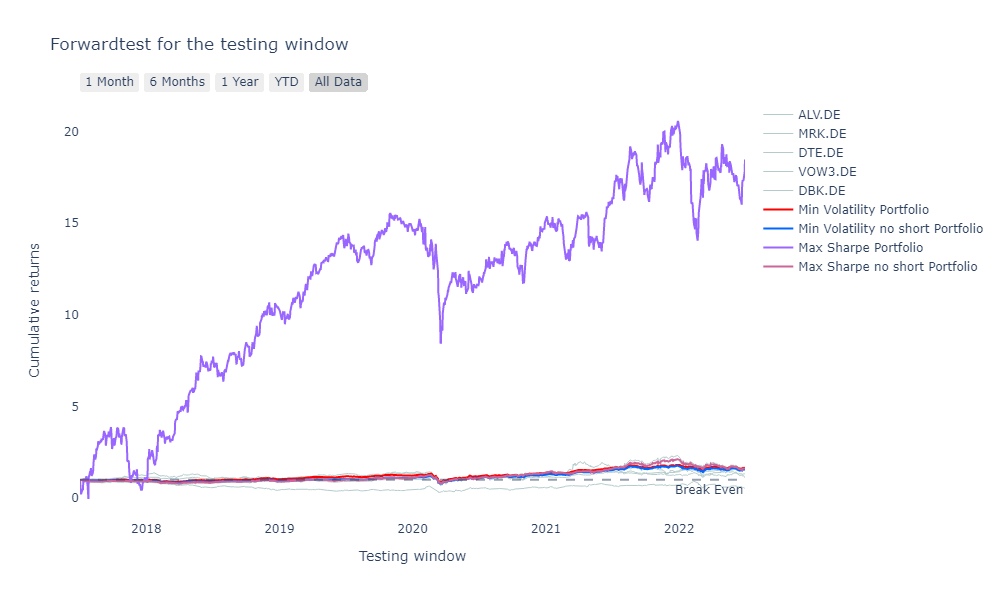

In [37]:
Image('Figure 4.png')

**Figure 4**: Cumulative returns of the stocks and portfolios when `HNR1.DE` is excluded during the testing window

This insight can be confirmed by excluding `DBK.DE` from the list of components. The new result shows that the trends in cumulative returns of these portfolios are not so different from each other. The only differenes are in their volatilities.

Forwardtest from 2017-07-01 00:00:00 to today\
Portfolios constructed from data collected from 2010-06-30 00:00:00 to 2017-06-30 00:00:00
1. The minimum volatility portfolio is: {'MRK.DE': 7, 'DTE.DE': 50, 'HNR1.DE': 7}
2. The minimum volatility no short portfolio is: {'MRK.DE': 7, 'DTE.DE': 49, 'HNR1.DE': 7}
3. The maximum Sharpe ratio portfolio is: {'MRK.DE': 10, 'HNR1.DE': 10, 'ALV.DE': -1, 'DTE.DE': -6, 'VOW3.DE': -3}
4. The maximum Sharpe ratio no short portfolio is: {'MRK.DE': 10, 'DTE.DE': 2, 'HNR1.DE': 10}

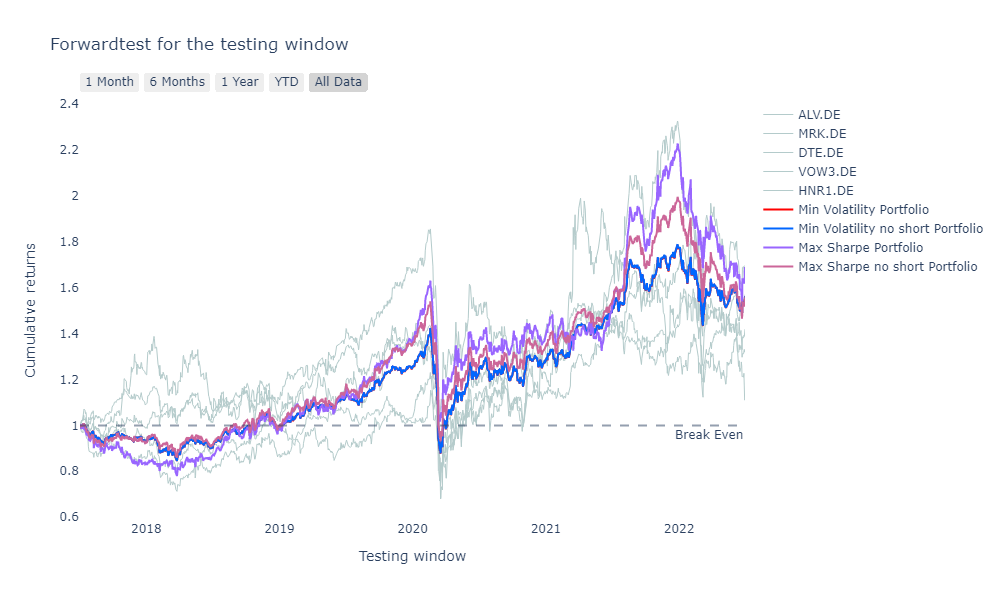

In [38]:
Image('Figure 5.png')

**Figure 5**: Cumulative returns of the stocks and portfolios when `DBK.DE` is excluded during the testing window

Another interesting insight is when `MRK.DE` is excluded from the list of components. The `Max Sharpe Portfolio` has deeply negative cumulative return. Hence, `MRK.DE` is the main source of positive return of the portfolio.

Forwardtest from 2017-07-01 00:00:00 to today\
Portfolios constructed from data collected from 2010-06-30 00:00:00 to 2017-06-30 00:00:00
1. The minimum volatility portfolio is: {'ALV.DE': 2, 'DTE.DE': 60, 'VOW3.DE': 1, 'HNR1.DE': 9, 'DBK.DE': -19}
2. The minimum volatility no short portfolio is: {'DTE.DE': 74, 'VOW3.DE': 1, 'HNR1.DE': 10}
3. The maximum Sharpe ratio portfolio is: {'ALV.DE': 6, 'DTE.DE': 16, 'VOW3.DE': 1, 'HNR1.DE': 9, 'DBK.DE': -134}
4. The maximum Sharpe ratio no short portfolio is: {'DTE.DE': 19, 'HNR1.DE': 18}

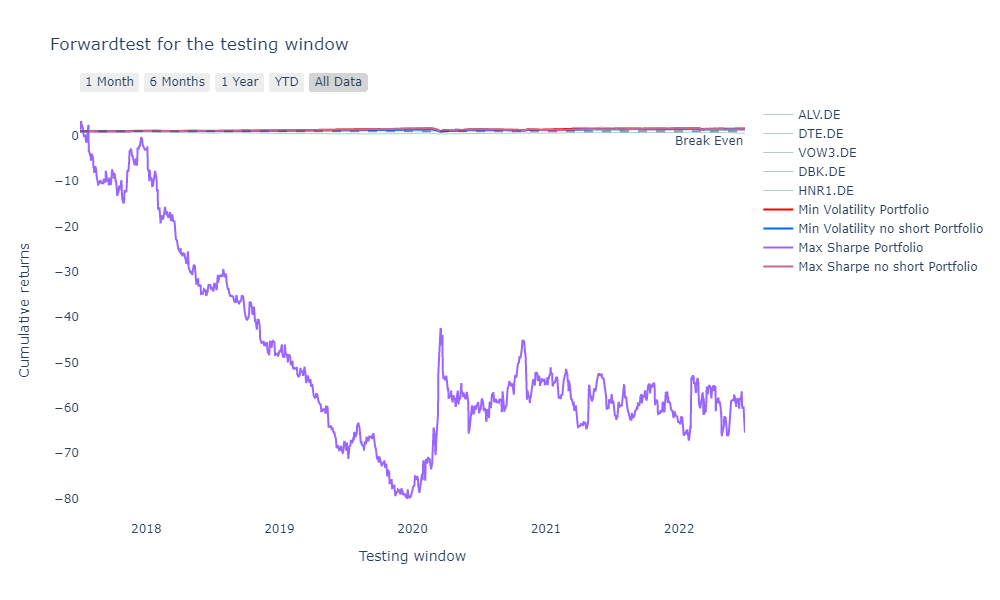

In [39]:
Image('Figure 6.png')

**Figure 6**: Cumulative returns of the stocks and portfolios when `MRK.DE` is excluded during the testing window

The exclusions of other stocks in the list more or less enhance or reduce the leverage effect by affecting the cumulative return of the `Max Sharpe Portfolio`.

The Forwardtest shows many interesting insights into the impacts of the portfolio components on their performance in the testing window. `DBK.DE` is a leverage for the enhancing portfolio performance. This makes sense because its cumulative return is very low, which means the cost of capital is also low. By selling `DBK.DE` and using the acquired capital to invest in other stocks with higher returns, it is a reasonable strategy to exploit the arbitrage opportunity if the strategy is executable. This is the core idea of short selling. Moreover, `MRK.DE` is the main source of positive return of the portfolio and contribute strongly to the return of these portfolios.

These insights help us understand more about the contribution of each stock into the overall performance of the portfolio. Each portfolio presents an investment strategy, which might not be practical in reality. For example, the strategies involving short selling might not be executable due to their complication because they require very strict management of the portfolio elements.

## Efficient Frontier

On the sigma-mu coordinates, the collection of all portfolios offering the lowest volatility for certain levels of return is regarded as the Efficient Frontier. That means we can trace out the Efficient Frontier by varying the required return and solve for the corresponding minimum volatility portfolio. The result is regarded as the Minimum Variance Frontier and the upper part of this frontier is regarded as the Efficient Frontier. This is the numerical approach to constructing the Efficient Frontier: by solving a series of optimization problems, we can have the Efficient Frontier. The Efficient Frontier can also be constructed analytically by solving for the mathematical formula of the Efficient Frontier. However this approach is limited as the optimization problem is sometime not solvable analytically. 

In this project, the brute force method is used to generate this frontier. The core idea of brute force method employs the mechanism of the Monte Carlo simulation to generate as many portfolios as possible. As the number of portfolios increases, the portfolios belonging to the Minimum Variance Frontier will be included in the generated portfolios. By sorting, we can figure out the Efficient Frontier. The package `finquant` provides a convenient way to construct the Efficient Frontier using this method.

[*********************100%***********************]  6 of 6 completed
----------------------------------------------------------------------
Stocks: ALV.DE, MRK.DE, DTE.DE, VOW3.DE, DBK.DE, HNR1.DE
Time window/frequency: 252
Risk free rate: 0.005
Portfolio Expected Return: 0.150
Portfolio Volatility: 0.217
Portfolio Sharpe Ratio: 0.668

Skewness:
   ALV.DE  MRK.DE  DTE.DE  VOW3.DE  DBK.DE  HNR1.DE
0  0.2183  0.2321  0.3271   0.4457 -0.3531   0.2963

Kurtosis:
   ALV.DE  MRK.DE  DTE.DE  VOW3.DE  DBK.DE  HNR1.DE
0 -1.0712 -1.2680 -1.5135  -0.2084 -0.5366  -1.3483

Information:
   Allocation     Name
0      0.1667   ALV.DE
1      0.1667   MRK.DE
2      0.1667   DTE.DE
3      0.1667  VOW3.DE
4      0.1667   DBK.DE
5      0.1667  HNR1.DE
----------------------------------------------------------------------


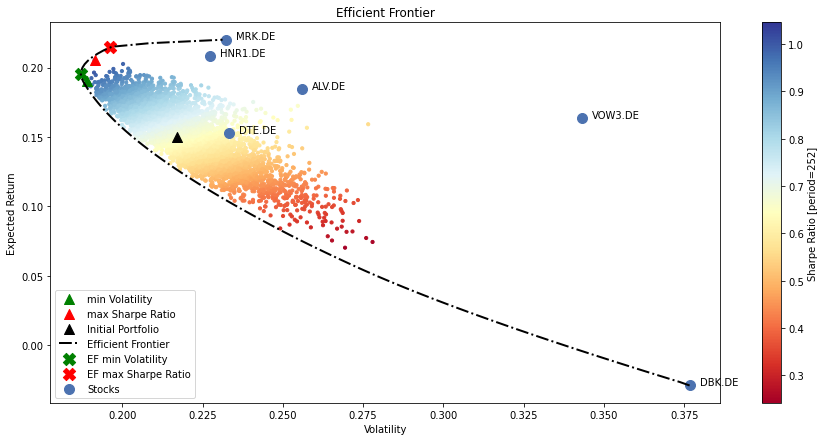

In [40]:
# https://github.com/fmilthaler/FinQuant
pf = build_portfolio(names = tickers,
                    start_date = start_train,
                    end_date = end_train,
                    data_api = 'yfinance')
pf.properties()

# performs and plots results of Monte Carlo run (5000 iterations)
opt_w, opt_res = pf.mc_optimisation(num_trials = 5000)

# plots the results of the Monte Carlo optimisation
plt.figure(figsize = (15, 7))
pf.mc_plot_results()

# plots the Efficient Frontiera
pf.ef_plot_efrontier()

# plots optimal portfolios based on Efficient Frontier
pf.ef.plot_optimal_portfolios()

# plots individual plots of the portfolio
pf.plot_stocks()

The Efficient Portfolio visualizes the relationship between expected returns and volatilities of the optimal portfolios. This is only theoretically useful because the investor might be more interested in a specific portfolio with desired characteristics rather than such a relationship in practice.

## Conclusion

This project presents a detailed process of constructing, optimizing, and validating stock portfolios to serve various investment preferences using a variety of Python packages. Data of six arbitrarily chosen stocks is fetched from Yahoo! Finance and analyzed to study their characteristics. Many statistics are calculated to describe and compare these stocks, then they are used for the portfolio optimization. Four optimal portfolios for different investment preferences are constructed from the six initial stocks. The results are the discrete stock allocations of these portfolios for a fund of two thousands EUR. Then their performance is validated in another separate time window to check whether these portfolios could perform consistently ex-ante and which portfolio is most appropriate to serve a certain preference. Through this validation process, we gain many insights to how each individual stock contributes to the characteristics of the constructed portfolios. Last but not least, an Efficient Frontier is visualized to demonstrate the theoretical relationship between expected returns and volatilities of the optimal portfolios.

The analysis results show many interesting knowledge that is useful for making investment strategy. Firstly, `DBK.DE` is an effective leverage that can enhance the portfolio performance if short selling is allowed and `MRK.DE` is the driving force of positive returns for the portfolios. Each specific portfolio can be considered as an investment strategy, the validation shows that `Max Sharpe Portfolio` offers the best performance in terms of Sharpe ratio, but a practical investor migh prefer the `Max Sharpe NS Portfolio` as it has the best performance in terms of portfolio value. In practice it is also not easy to implement an investment strategy with short selling, so I would also prefer the `Max Sharpe NS Portfolio` to the other options if I were the actual investor.

## References

1. [Basic interactive stock analysis template](https://medium.com/@huangchingchiu/basic-interactive-stock-analysis-template-286f06973a86)
2. [Practical portfolio optimization](https://pythoninvest.com/long-read/practical-portfolio-optimisation)
3. [FinQuant documentation](https://github.com/fmilthaler/FinQuant)